<a href="https://colab.research.google.com/github/carlosvneves/fiap_techchallenge04/blob/main/TechChallenge04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech Challenge 04 - Alura Pós-Tech/FIAP
---

Notebook para testes e exploração de ideiais na solução do desafio da fase 04 do curso **Alura Pós-Tech/FIAP**.

## Descrição do problema

Você foi contratado(a) para uma consultoria, e seu trabalho envolve analisar os dados de preço do petróleo brent, que pode ser encontrado no site do ipea. Essa base de dados histórica envolve duas colunas: data e preço (em dólares).

Um grande cliente do segmento pediu para que a consultoria desenvolvesse um dashboard interativo e que gere insights relevantes para tomada de decisão. Além disso, solicitaram que fosse desenvolvido um modelo de Machine Learning para fazer o forecasting do preço do petróleo.

Seu objetivo é:

- Criar um dashboard interativo com ferramentas à sua escolha.

- Seu dashboard deve fazer parte de um storytelling que traga insights relevantes sobre a variação do preço do petróleo, como situações geopolíticas, crises econômicas, demanda global por energia e etc. Isso pode te ajudar com seu modelo. É obrigatório que você traga pelo menos 4 insights neste desafio.

- Criar um modelo de Machine Learning que faça a previsão do preço do petróleo diariamente (lembre-se de time series). Esse modelo deve estar contemplado em seu storytelling e deve conter o código que você trabalhou, analisando as performances do modelo.

- Criar um plano para fazer o deploy em produção do modelo, com as ferramentas que são necessárias.

- Faça um MVP do seu modelo em produção utilizando o Streamlit.

# Instalação de dependências e carregamento de bibliotecas

In [2]:
# biblioteca para obter dados do ipeadata
!pip install ipeadatapy

In [4]:
# carregamento de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import ipeadatapy as ip


In [12]:
# metadados das séries
ip_metadata = ip.metadata()

In [15]:
# busca do código da série de Preço - petróleo bruto - Brent (FOB)
ip_metadata[ip_metadata['NAME'].str.contains('Brent') == True]

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
5710,EIA366_PBRENT366,Preço - petróleo bruto - Brent (FOB),Preço por barril do petróleo bruto tipo Brent....,2024-05-09T11:28:00.997-03:00,Macroeconômico,EIA,Energy Information Administration (EIA),www.eia.doe.gov,Diária,US$,None,A,11,BRA,True


In [17]:
# seleção da série com dados a partir de 2001
petr_brent = ip.timeseries('EIA366_PBRENT366', yearGreaterThan = 2001)

In [18]:
petr_brent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7595 entries, 2002-01-01 to 2024-05-03
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CODE         7595 non-null   object 
 1   RAW DATE     7595 non-null   object 
 2   DAY          7595 non-null   int32  
 3   MONTH        7595 non-null   int32  
 4   YEAR         7595 non-null   int32  
 5   VALUE (US$)  7454 non-null   float64
dtypes: float64(1), int32(3), object(2)
memory usage: 326.3+ KB


<Axes: xlabel='RAW DATE'>

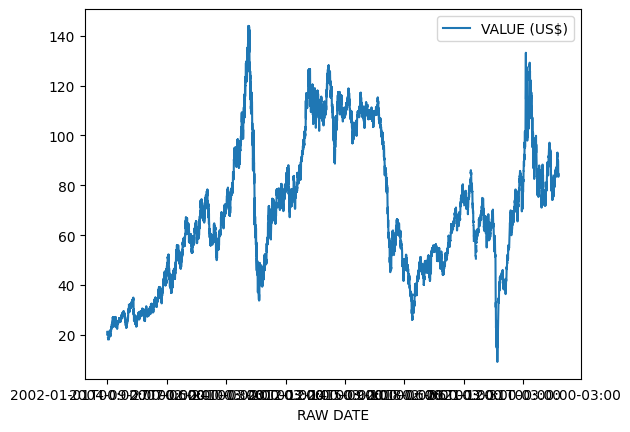

In [26]:
petr_brent.plot('RAW DATE','VALUE (US$)')

In [25]:
# gráfico da série temporal
px.line(petr_brent,
  x = 'RAW DATE',
  y = 'VALUE (US$)',
)


In [21]:
petr_brent.head()

,CODE,RAW DATE,DAY,MONTH,YEAR,VALUE (US$)
DATE,,,,,,
2002-01-01,EIA366_PBRENT366,2002-01-01T00:00:00-02:00,1,1,2002,NaN
2002-01-02,EIA366_PBRENT366,2002-01-02T00:00:00-02:00,2,1,2002,20.13
2002-01-03,EIA366_PBRENT366,2002-01-03T00:00:00-02:00,3,1,2002,20.47
2002-01-04,EIA366_PBRENT366,2002-01-04T00:00:00-02:00,4,1,2002,21.20
2002-01-05,EIA366_PBRENT366,2002-01-05T00:00:00-02:00,5,1,2002,NaN


A série de interesse é diária epossui dados a partir de janeiro de 2002.

# Análise Exploratória da Série

# Modelo de Machine Learning